In [1]:
import torch
import einops

import matplotlib.pyplot as plt

from utils.config import *
from utils.loss_fn import f_kernel_crps

In [139]:

# BASE INTERFACE
class MaskingStrategy(torch.nn.Module):
    def __init__(self, world, schedule: str = 'linear'):
        super().__init__()
        self.world = world
        self.schedule = getattr(self, f"{schedule}_schedule")

    def sample_prior(self, S: int, device: torch.device, **kwargs) -> torch.FloatTensor:
        raise NotImplementedError
    
    def sample_timesteps(self, S: int, device: torch.device, **kwargs) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        raise NotImplementedError
    
    def sample_masks(self, prior: torch.FloatTensor, rates: torch.FloatTensor, **kwargs) -> torch.BoolTensor:
        raise NotImplementedError

    def forward(self, S: int, device: torch.device, rng: torch.Generator = None, **kwargs) -> tuple[torch.BoolTensor, torch.FloatTensor]:
        prior = self.sample_prior(S, device, rng = rng, **kwargs)
        rates, weights = self.sample_timesteps(S, device, rng = rng, **kwargs)
        masks = self.sample_masks(prior, rates, **kwargs)
        return masks, weights

    # SELECT
    @staticmethod
    def binary_topk(prior: torch.FloatTensor, rates: torch.FloatTensor, **kwargs) -> torch.BoolTensor:
        ks = (prior.size(-1) * rates).long()
        idx = prior.argsort(dim=-1, descending=False)
        rank = torch.arange(prior.size(-1), device=prior.device).expand_as(prior)
        mask = torch.zeros_like(prior, dtype=torch.bool, device=prior.device)
        mask.scatter_(dim = -1, index = idx, src= ks > rank) # True for top-k False otherwise
        return mask
    
    # SAMPLING
    @staticmethod
    def log_dirichlet(shape: tuple, alpha: float, device: torch.device,  eps: float = 1e-7, rng: torch.Generator = None, **kwargs) -> torch.FloatTensor:
        return torch.log(torch._sample_dirichlet(torch.full(shape, alpha, device=device), generator=rng) + eps)
    
    @staticmethod
    def gumbel(shape: tuple, device: torch.device, eps: float = 1e-7, rng: torch.Generator = None, **kwargs) -> torch.FloatTensor:
        return -torch.log(-torch.log(torch.rand(shape, device=device, generator=rng) + eps) + eps)
    
    # SCHEDULES
    @staticmethod
    def cosine_schedule(t: torch.FloatTensor, **kwargs) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        rates = torch.cos(torch.pi * (1 - t) / 2)
        weights = 0.5 * torch.pi * torch.sin(torch.pi * (1 - t) / 2)
        return rates, weights

    @staticmethod
    def linear_schedule(t: torch.FloatTensor, **kwargs) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        return t, torch.ones_like(t)
    
# FRAME-WISE DIRICHLET PRIOR    
class DirichletMasking(MaskingStrategy):
    def __init__(self, world, alpha: float = 1.0, schedule: str = "cosine", stratify: bool = True, progressive: bool = True):
        super().__init__(world, schedule = schedule)
        self.alpha = alpha
        self.stratify = stratify
        self.progressive = progressive

    def sample_prior(self, S: int, device: torch.device, rng: torch.Generator = None, **kwargs) -> torch.FloatTensor:
        B, N, T = self.world.batch_size, self.world.num_tokens, self.world.token_sizes["t"]
        log_dirichlet = self.log_dirichlet((1, B, T), self.alpha, device, generator=rng)
        gumbel_noise = self.gumbel((1, B, N), device, generator=rng)
        log_dirichlet = einops.repeat(log_dirichlet, f"1 b t -> 1 b {self.world.flat_token_pattern}", **self.world.token_sizes)
        prior = log_dirichlet + gumbel_noise
        return prior.expand(S, -1, -1)

    def sample_timesteps(self, S: int, device: torch.device, rng: torch.Generator = None, eps: float = 1e-2, **kwargs
                         ) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        B, N = self.world.batch_size, self.world.num_tokens
        t = torch.rand((S, B, 1), device=device, generator=rng).expand(-1, -1, N)
        # add batch-level stratification for low-discrepancy sampling
        if self.stratify: 
            bs = torch.linspace(0, 1, B, device = device).view(1, -1, 1)
            t = (t + bs) % 1
        # sort timesteps for progressive masking
        if self.progressive: 
            t = t.sort(dim=0, descending = True).values  
        t_adj = t * (1 - 2*eps) + eps  # maps t ∈ [0,1] → [eps, 1-eps]
        rates, weights = self.schedule(t_adj)
        return rates, weights
    
    def sample_masks(self, prior: torch.FloatTensor, rates: torch.FloatTensor, **kwargs) -> torch.BoolTensor:
        return self.binary_topk(prior, rates)

# FORECAST MASKING STRATEGIES    
class ForecastMasking(MaskingStrategy):
    def __init__(self, world, tau: int, schedule: str = "linear", noise_scale: float = 0.0):
        super().__init__(world, schedule=schedule)
        T = self.world.token_sizes["t"]
        N = self.world.num_tokens

        self.prefix_frames = tau
        self.frcst_frames = T - tau
        self.tokens_per_frame = N // T
        self.prefix_length = tau * self.tokens_per_frame
        self.frcst_length = N - self.prefix_length
        self.noise_scale = noise_scale

    def sample_prior(self, S: int,device: torch.device, rng: torch.Generator = None, **kwargs) -> torch.FloatTensor:
        # base frame order repeated per token
        B = self.world.batch_size
        frames = torch.arange(self.frcst_frames, 0, -1, device=device).float()
        frames = einops.repeat(frames, 'f -> s b (f n)', s=S, b=B, n=self.tokens_per_frame)

        if self.noise_scale > 0.0:
            noise = self.gumbel((S, B, self.frcst_length), device=device, generator=rng)
            frames = frames + self.noise_scale * noise

        return frames

    def sample_timesteps(self, S: int,device: torch.device, **kwargs) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        t = torch.linspace(1.0, 1 / S, steps=S, device=device)
        t = einops.repeat(t, "s -> s b f", b=self.world.batch_size, f = self.frcst_length)
        rates, weights = self.schedule(t)
        return rates, weights

    def sample_masks(self, prior: torch.FloatTensor, rates: torch.FloatTensor, **kwargs) -> torch.BoolTensor:
        frcst_mask = self.binary_topk(prior, rates)
        prefix_mask = frcst_mask.new_zeros(frcst_mask.size(0), frcst_mask.size(1), self.prefix_length)
        return torch.cat([prefix_mask, frcst_mask], dim=-1)

In [166]:
world = WorldConfig(
    field_sizes={"v": 6, "t": 36, "h": 64, "w": 120},
    patch_sizes={"vv": 6, "tt": 6, "hh": 4, "ww": 4},
    batch_size= 128,
)

In [171]:
dm = DirichletMasking(world, alpha = 0.5, stratify=True, schedule= "cosine")
fm = ForecastMasking(world, 2)

In [178]:
m, w = dm.sample_timesteps(4, "cpu")

In [179]:
m.shape

torch.Size([4, 128, 2880])

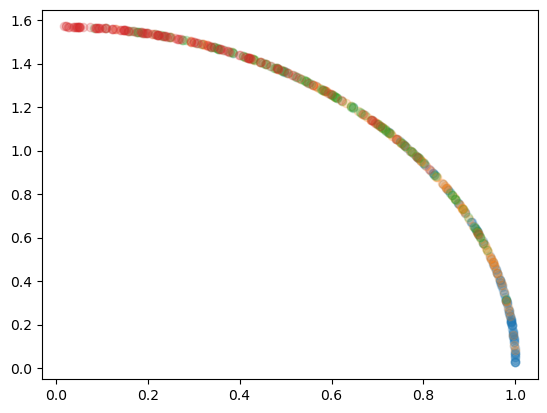

In [180]:
for ms, ws in zip(m, w):
    plt.plot(ms[:, 0],ws[:, 0], "o", alpha=0.2)


In [ ]:
def setup_misc(self):
    # make sure we can distinguish between the two stages in wandb
    self.cfg.wb_tags = default(self.cfg.wb_tags, [])
    self.cfg.wb_tags.append(f"stage{self.current_stage}")

    # stage 1 doesn't need any further setup
    if self.current_stage == 1:
        return

    #stage 2 needs to load the pretrained weights
    pretrained_path = self.parse_stage1_id()
    self.load_pretrained(pretrained_path)

def parse_stage1_id(self):
    # load stage 1 model via its slurm id
    slurm_id_stage1 = default(self.cfg.stage1_id, str(self.slurm_id))
    if slurm_id_stage1.endswith("_stage1"):
        slurm_id_stage1 = slurm_id_stage1.strip("_stage1")
    self.cfg.stage1_id = slurm_id_stage1 # store the stage 1 id in the config for logging
    path = Path(self.cfg.model_dir) / f"{slurm_id_stage1}_stage1" / "ckpt.pth"
    return path

def create_job_name(self):
    stage_tag = f"stage{self.current_stage}"

    if exists(self.cfg.job_name):
        base_name = str(self.cfg.job_name).replace('/', '_')
        if base_name.endswith("_stage1"):
            base_name = base_name.strip("_stage1")
        if base_name.endswith("_stage2"):
            base_name = base_name.strip("_stage2")
    else:
        base_name = self.slurm_id

    self.job_name = f"{base_name}_{stage_tag}"
    self.cfg.job_name = self.job_name # enables resuming from config by using the job name

def set_current_stage(self, stage: int):
    self.current_stage = stage
    

In [ ]:
import torch
import einops

class Masking:
    def __init__(self, masking_cfg, world_cfg, optim_cfg, device, generator=None):
        self.masking = masking_cfg
        self.world = world_cfg
        self.optim_cfg = optim_cfg
        self.device = device
        self.generator = generator

    def get_timestep(self, timestep: str):
        if timestep == "uniform":
            t = self.single_timestep()
            lhs = 'b 1'
        elif timestep == "framewise":
            t = self.framewise_timestep()
            lhs = 'b t'
        elif timestep == 'history':
            t = self.history_timestep()
            lhs = 't'
        else:
            raise ValueError(f"Unknown timestep: {timestep}")
        return einops.repeat(t, f"{lhs} -> {self.world.flat_mask_pattern}", **self.world.token_sizes,b=self.optim_cfg.batch_size,)

    def get_schedule(self, t, schedule: str):
        if schedule == "cosine":
            rate = self.cosine_schedule(t)
            weight = self.cosine_weight(t, self.masking.eps)
        elif schedule == "arcsine":
            rate = self.arcsine_schedule(t)
            weight = self.arcsine_weight(t, self.masking.eps)
        elif schedule == "uniform":
            rate = (self.masking.rate_max - self.masking.rate_min) * t + self.masking.rate_min
            weight = torch.ones_like(rate)
        else:
            raise ValueError(f"Unknown schedule: {schedule}")
        return rate, weight
    
    def get_mask(self, rate, mask: str):
        if mask == "bernoulli":
            visible = torch.bernoulli(rate, generator=self.generator).bool()
        elif mask == "topk":
            G = self.gumbel_noise((self.optim_cfg.batch_size, self.world.num_tokens))
            ks = self.k_from_rates(rate)
            if self.masking.alphas:
                G = G + self.dirichlet_joint()
            visible = self.binary_topk(G, ks=ks)
        else:
            raise ValueError(f"Unknown mask: {mask}")
        return visible

    def __call__(self,
                timestep: str = "uniform", 
                schedule: str = "cosine", 
                mask: str = "bernoulli"
                ):
        
        # pick timestep Float: (B, N, 1)
        t = self.get_timestep(timestep) 

        # pick schedule (elementwise) Float: (B, N, 1)
        rate, weight = self.get_schedule(t, schedule)

        # pick mask generator Boolean: (B, N, 1)
        visible = self.get_mask(rate, mask)

        return visible, weight

    # SAMPLING
    def uniform(self, shape: tuple):
        return torch.rand(shape, device=self.device, generator=self.generator)

    def gumbel_noise(self, shape: tuple):
        return -torch.log(-torch.log(self.uniform(shape)))

    # DIRICHLET
    def dirichlet_joint(self):
        D = einops.reduce(
            [self.dirichlet_marginal(ax).log() for ax in self.masking.alphas.keys()],
            "factors ... -> ...",
            "sum",
        )
        return D
    
    def dirichlet_marginal(self, ax: str):
        concentration = torch.full(
            (self.optim_cfg.batch_size, self.world.token_sizes[ax]),
            self.masking.alphas[ax],
            device=self.device,
        )
        probs = torch._sample_dirichlet(concentration, generator=self.generator)
        return einops.repeat(
            probs,
            f"b {ax} -> b {self.world.flat_token_pattern}",
            **self.world.token_sizes,
            b=self.optim_cfg.batch_size,
        )

    # TIMESTEPS
    def framewise_timestep(self):
        T = self.world.token_sizes["t"]
        B = self.optim_cfg.batch_size
        if self.masking.stratification:
            t = self.uniform((1, T))
            t = (t + torch.linspace(0, 1, B, device=t.device).view(-1, 1)) % 1
        else:
            t = self.uniform((B, T))
        f = self.masking.tail_frac
        t = torch.where(t > f, (t - f) / (1 - f), torch.zeros_like(t))
        return t

    def single_timestep(self):
        B = self.optim_cfg.batch_size
        if self.masking.stratification:
            t = self.uniform((1,))
            t = (t + torch.linspace(0, 1, B, device=t.device).view(-1, 1)) % 1
        else:
            t = self.uniform((B, 1))
        return t
    
    def history_timestep(self):
        t = torch.zeros((self.world.token_sizes["t"],), device=self.device)
        t[: self.world.tau] = 1.0
        return t
    
    # TOPK 
    def k_from_rates(self, rates):
        return (self.world.num_tokens * rates).long()

    def binary_topk(self, weights, ks):
        index = weights.argsort(dim=-1, descending=True)
        pos = torch.arange(weights.size(-1), device=weights.device)
        index = einops.rearrange(index, "b n -> b n 1")
        pos = einops.rearrange(pos, "n -> 1 n 1")
        binary = torch.zeros_like(index, dtype=torch.bool, device=self.device).scatter(1, index, ks > pos)
        return binary

    # SCHEDULES
    @staticmethod
    def arcsine_schedule(t: torch.Tensor):
        return 0.5 - 0.5 * torch.cos(torch.pi * t)

    @staticmethod
    def arcsine_weight(t: torch.Tensor, eps: float = 1e-3):
        t_adj = t * (1 - 2*eps) + eps  # maps t ∈ [0,1] → [eps, 1-eps]
        return 0.5 * torch.pi * torch.sin(torch.pi * t_adj)

    @staticmethod
    def cosine_schedule(t: torch.Tensor):
        return 1 - torch.cos(torch.pi * t / 2)

    @staticmethod
    def cosine_weight(t: torch.Tensor, eps: float = 1e-3):
        t_adj = t * (1 - 2*eps) + eps  # maps t ∈ [0,1] → [eps, 1-eps]
        return 0.5 * torch.pi * torch.sin(torch.pi * t_adj / 2)




In [ ]:
class MaskingStrategy(torch.nn.Module):
    def __init__(self, world, schedule: str):
        super().__init__()
        self.world = world
        self.schedule = getattr(self, f"{schedule}_schedule", default = self.linear_schedule)

    def sample_prior(self, S: int, B: int, device: torch.device, **kwargs) -> torch.FloatTensor:
        raise NotImplementedError
    
    def sample_timesteps(self, S: int, B: int, device: torch.device, **kwargs) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        raise NotImplementedError
    
    def sample_masks(self, prior: torch.FloatTensor, rates: torch.FloatTensor, **kwargs) -> torch.BoolTensor:
        raise NotImplementedError

    def forward(self, S: int, B: int, device: torch.device, rng: torch.Generator = None, **kwargs) -> tuple[torch.BoolTensor, torch.FloatTensor]:
        prior = self.sample_prior(S, B, device, rng = rng, **kwargs)
        rates, weights = self.sample_timesteps(S, B, device, rng = rng, **kwargs)
        masks = self.sample_masks(prior, rates, **kwargs)
        return masks, weights

    # SELECT
    @staticmethod
    def binary_topk(prior: torch.FloatTensor, rates: torch.FloatTensor, **kwargs) -> torch.BoolTensor:
        ks = (prior.size(-1) * rates).long()
        idx = prior.argsort(dim=-1, descending=True)
        rank = torch.arange(prior.size(-1), device=prior.device).expand_as(prior)
        mask = torch.zeros_like(prior, dtype=torch.bool, device=prior.device)
        mask.scatter_(dim = -1, index = idx, src= ks > rank) # True for top-k False otherwise
        return mask
    
    # SAMPLING
    @staticmethod
    def log_dirichlet(shape: tuple, alpha: float, device: torch.device,  eps: float = 1e-7, rng: torch.Generator = None, **kwargs) -> torch.FloatTensor:
        return torch.log(torch._sample_dirichlet(torch.full(shape, alpha, device=device), generator=rng) + eps)
    
    @staticmethod
    def gumbel(shape: tuple, device: torch.device, eps: float = 1e-7, rng: torch.Generator = None, **kwargs) -> torch.FloatTensor:
        return -torch.log(-torch.log(torch.rand(shape, device=device, generator=rng) + eps) + eps)
    
    # SCHEDULES
    @staticmethod
    def cosine_schedule(t: torch.FloatTensor, **kwargs) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        rates = 1 - torch.cos(torch.pi * t / 2)
        weights = 0.5 * torch.pi * torch.sin(torch.pi * t / 2)
        return rates, weights

    @staticmethod
    def linear_schedule(t: torch.FloatTensor, **kwargs) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        return t, torch.ones_like(t)
    
class DirichletMasking(MaskingStrategy):
    def __init__(self, world, alpha: float = 1.0, schedule: str = "cosine"):
        super().__init__(world, schedule = schedule)
        self.alpha = alpha

    def sample_prior(self, S: int, B: int, device: torch.device, rng: torch.Generator = None, **kwargs) -> torch.FloatTensor:
        N, T = self.world.num_tokens, self.world.token_sizes["t"]
        log_dirichlet = self.log_dirichlet((S, B, T), self.alpha, device, generator=rng)
        gumbel_noise = self.gumbel((S, B, N), device, generator=rng)
        prior = einops.repeat(log_dirichlet, f"s b t -> s b {self.world.flat_token_pattern}", n=N) + gumbel_noise
        return prior

    def sample_timesteps(self, S: int, B: int, device: torch.device, rng: torch.Generator = None, **kwargs) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        t = torch.rand((S, B, 1), device=device, generator=rng)
        t = t.sort(dim=0).values  # sort timesteps for progressive masking
        rates, weights = self.schedule(t)
        return rates, weights
    
    def sample_masks(self, prior: torch.FloatTensor, rates: torch.FloatTensor, **kwargs) -> torch.BoolTensor:
        return self.binary_topk(prior, rates)
    

class ForecastMasking(MaskingStrategy):
    def __init__(self, world, schedule: str = "linear"):
        super().__init__(world, schedule = schedule)
        self.tau = self.world.tau

    def sample_prior(self, S: int, B: int, device: torch.device, **kwargs) -> torch.FloatTensor:
        prior = torch.arange(self.world.num_tokens, device=device).float()
        prior = einops.repeat(prior, "n -> s b n", s=S, b=B)
        return prior

    def sample_timesteps(self, S: int, B: int, device: torch.device, **kwargs) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        T = self.world.token_sizes["t"]
        start = (self.tau / T).float()
        t = torch.linspace(start, 1.0, steps=S, device=device)
        t = einops.repeat(t, "s -> s b ()", b=B)
        rates, weights = self.schedule(t) 
        return rates, weights
    
    def sample_masks(self, prior: torch.FloatTensor, rates: torch.FloatTensor, **kwargs) -> torch.BoolTensor:
        return self.binary_topk(prior, rates)
    

In [2]:
world = WorldConfig(
    field_sizes = {'v': 4, 't': 36, 'h': 64, 'w': 120},
    patch_sizes={'vv': 4, 'tt': 6, 'hh': 4, 'ww': 4},
    batch_size=2,
    tau=2,
)

model = NetworkConfig(
    dim = 128,
    num_layers=4,
    num_compute_blocks=4,
    num_latents=256,
    dim_noise=32,
)


In [29]:
tokens = torch.randn((world.batch_size, world.num_tokens, world.dim_tokens), device = ao_rin.device)

pred, mask, weights = ao_rin(tokens, num_steps = 2, num_ensemble = 4, prior = 'dirichlet', schedule = 'cosine')

tokens, pred = map(lambda x: einops.rearrange(x, 
                                              f'{world.flatland_pattern} ... -> {world.field_pattern} ...', 
                                              **world.token_sizes, **world.patch_sizes), 
                                              (tokens, pred)
                                              )
mask = einops.repeat(mask, f'b {world.flat_token_pattern} -> {world.field_pattern}', **world.token_sizes, **world.patch_sizes)
weights = einops.repeat(weights, f'b 1 -> {world.field_pattern}', **world.token_sizes, **world.patch_sizes)

In [30]:
print(pred.shape, mask.shape, weights.shape)

torch.Size([2, 4, 36, 64, 120, 4]) torch.Size([2, 4, 36, 64, 120]) torch.Size([2, 4, 36, 64, 120])


In [32]:
loss = f_kernel_crps(observation=tokens, ensemble=pred, fair=True)
masked_loss = (loss * weights)[mask].mean()

In [33]:
loss.shape

torch.Size([2, 4, 36, 64, 120])

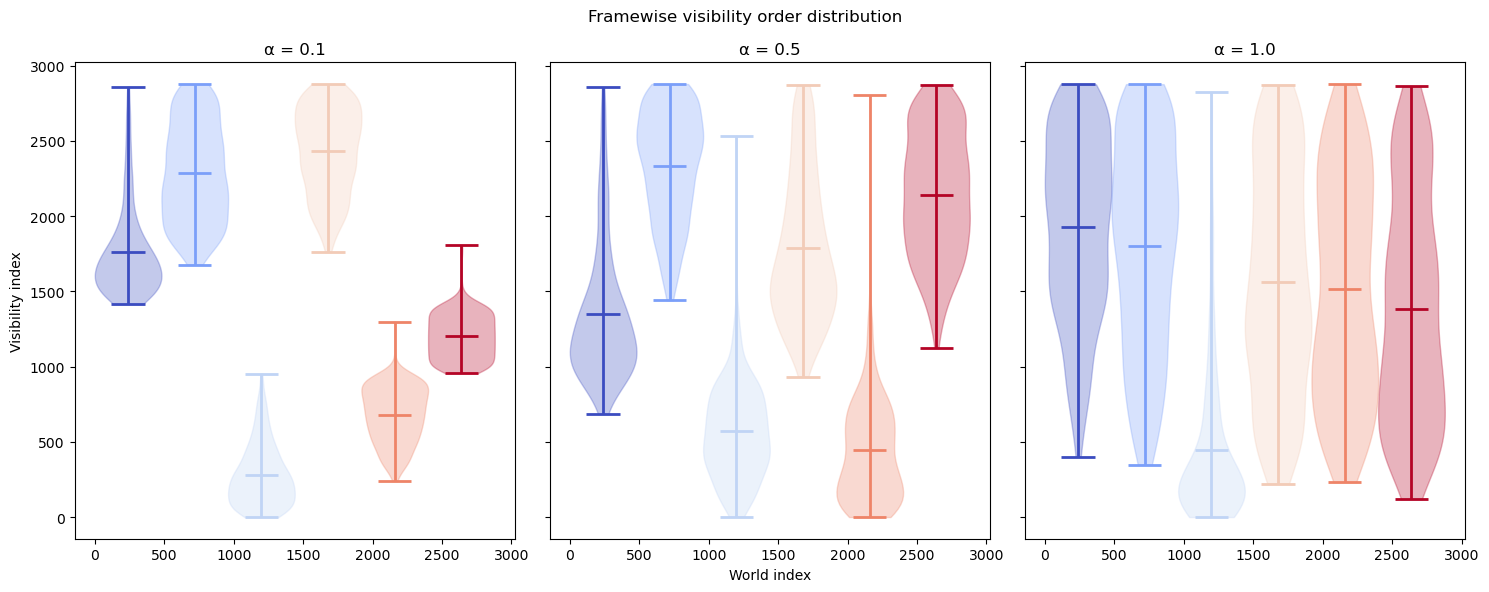

In [252]:
T, S = 6, 480
alphas = [0.1, 0.5, 1.0]
colors = plt.cm.coolwarm(torch.linspace(0, 1, T))
fig, ax = plt.subplots(1, 3, figsize=(15, 6), sharey=True, sharex=True)
g = torch.rand((T * S)).log().neg().log().neg()

for i,alpha in enumerate(alphas):
    plt.sca(ax[i])
    a = torch.full((T,), alpha)
    ld = torch._sample_dirichlet(a).log().repeat_interleave(S, -1)
    sorted_vals, sorted_idx = torch.sort(ld + g, dim=-1)

    data = []
    positions = []
    for t in range(T):
        ids = torch.arange(t * S, (t + 1) * S)
        order_pos = (sorted_idx == ids.unsqueeze(1)).nonzero(as_tuple=False)[:, 1].numpy()
        data.append(order_pos)
        positions.append(ids.float().mean().item())  # center each violin at mean element index

    parts = plt.violinplot(data, positions=positions, widths=S, showextrema=True, showmeans=True)

    for pc, c in zip(parts['bodies'], colors):
        pc.set_facecolor(c)
        pc.set_edgecolor(c)

    # ensure extrema lines also match
    for key in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
        if key in parts:
            parts[key].set_color([colors[i] for i in range(T)])
            parts[key].set_linewidth(2.0)
    plt.title(f'α = {alpha}')
# label setup
ax[1].set_xlabel("World index")
ax[0].set_ylabel("Visibility index")
plt.suptitle('Framewise visibility order distribution')
plt.tight_layout()
plt.show()
